In [1]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
raw_train = pd.read_csv('../data/Train.csv')
raw_test = pd.read_csv('../data/Test.csv')

In [4]:
# mask = raw_train.duplicated()
# dup_idx = raw_train.loc[mask].index

# raw_train = raw_train.drop(dup_idx)

In [5]:
print(raw_train.info())
raw_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9053 entries, 0 to 9052
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mass_npea       9053 non-null   float64
 1   size_npear      9053 non-null   float64
 2   malign_ratio    9053 non-null   float64
 3   damage_size     9053 non-null   float64
 4   exposed_area    9053 non-null   float64
 5   std_dev_malign  9053 non-null   float64
 6   err_malign      9053 non-null   float64
 7   malign_penalty  9053 non-null   int64  
 8   damage_ratio    9053 non-null   float64
 9   tumor_size      9053 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 707.4 KB
None


,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
0,6930.90,2919.02,0.42116,51.8298,9.888294e+05,109.487,2758.76,72,39.3620,14.103
1,15635.70,4879.36,0.31206,223.5500,2.058426e+06,248.881,5952.53,240,22.0253,2.648
2,10376.20,2613.88,0.25191,127.3370,1.434676e+06,160.093,4635.26,73,29.9963,1.688
3,13093.80,4510.06,0.34444,155.4400,1.812195e+06,173.015,5273.87,32,28.1354,3.796
4,7545.21,2882.36,0.38201,85.1237,1.043918e+06,124.414,3263.35,57,35.0200,18.023


In [6]:
print(raw_test.shape)
raw_test.head(2)

(36584, 9)


,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio
0,4946.44,914.06,0.18479,54.5566,662834.4535,67.0525,2301.76,22,41.9554
1,5613.85,1629.12,0.29019,51.5524,784227.1281,80.1986,3235.00,48,40.7410


In [7]:
raw_train.describe()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
count,9053.000000,9053.000000,9053.000000,9053.000000,9.053000e+03,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000
mean,9907.197537,3034.689585,0.303123,103.938154,1.373060e+06,146.342446,3994.656338,69.909754,34.459824,7.741067
std,4062.414481,1463.877241,0.062539,55.443225,5.649211e+05,70.514977,1786.520634,55.816236,5.975403,6.093301
min,2864.760000,510.530000,0.114820,10.310100,3.878534e+05,31.970400,1089.190000,0.000000,15.228000,0.000000
25%,6989.850000,1983.800000,0.259050,64.040700,9.600373e+05,95.871900,3180.310000,31.000000,30.291500,2.325000
50%,8899.290000,2685.640000,0.301070,88.503300,1.237752e+06,126.193000,3846.670000,54.000000,35.238600,5.096000
75%,12117.300000,3832.300000,0.343090,134.182000,1.692430e+06,182.234000,4666.400000,91.000000,38.802600,13.367000
max,36995.400000,13535.000000,0.525300,346.420000,4.978616e+06,528.890000,91983.700000,340.000000,46.546400,20.999000


In [47]:
df = raw_train.append(raw_test).reset_index(drop=True)

In [48]:
df.describe()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
count,45637.000000,45637.000000,45637.000000,45637.000000,4.563700e+04,45637.000000,45637.000000,45637.000000,45637.000000,9053.000000
mean,9872.355210,3017.704983,0.302398,103.498747,1.368413e+06,145.644283,3990.090721,69.987247,34.523428,7.741067
std,4058.504267,1464.638433,0.062888,55.422265,5.640847e+05,69.998808,1995.023152,56.500909,5.980287,6.093301
min,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000,0.000000
25%,6937.080000,1979.060000,0.258720,63.566400,9.536292e+05,94.757500,3166.130000,31.000000,30.425700,2.325000
50%,8899.290000,2668.320000,0.300150,87.757000,1.237298e+06,126.185000,3840.170000,54.000000,35.298900,5.096000
75%,12124.600000,3786.700000,0.342920,133.631000,1.690883e+06,181.454000,4644.200000,91.000000,38.869600,13.367000
max,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900,20.999000


In [37]:
df['exposed_area'].skew()

1.0590309588330191

In [42]:
stats.skew(np.log(df['exposed_area']))

0.10751275616472775

In [49]:
for col in raw_test.columns.tolist():
    pt = PowerTransformer(standardize=True)
    sc = StandardScaler()
    
    if col == 'exposed_area':
        df[col] = np.log(df[col])
        df[col] = sc.fit_transform(df[[col]]).ravel()
        
    else:
        df[col] = pt.fit_transform(df[[col]]).ravel()

In [50]:
df.describe()

,mass_npea,size_npear,malign_ratio,damage_size,exposed_area,std_dev_malign,err_malign,malign_penalty,damage_ratio,tumor_size
count,4.563700e+04,4.563700e+04,4.563700e+04,4.563700e+04,4.563700e+04,4.563700e+04,4.563700e+04,4.563700e+04,4.563700e+04,9053.000000
mean,1.297557e-15,1.289150e-15,9.945761e-16,-1.677919e-15,-4.960736e-15,-9.753478e-16,3.003346e-15,1.880010e-16,4.545499e-16,7.741067
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,6.093301
min,-3.712698e+00,-3.791741e+00,-3.826264e+00,-4.800137e+00,-3.468425e+00,-3.256478e+00,-2.195702e+01,-3.515128e+00,-2.516503e+00,0.000000
25%,-6.859155e-01,-6.608996e-01,-6.766003e-01,-6.914681e-01,-7.108031e-01,-6.912241e-01,-5.434739e-01,-6.542046e-01,-7.560755e-01,2.325000
50%,-3.848544e-02,-3.862589e-02,3.837215e-03,-3.840969e-02,-5.412093e-02,-5.682083e-02,5.030781e-02,-1.539542e-02,4.801229e-02,5.096000
75%,7.355865e-01,7.044699e-01,6.697658e-01,7.759312e-01,7.334651e-01,7.221121e-01,6.392871e-01,6.541888e-01,7.111755e-01,13.367000
max,3.438969e+00,3.828496e+00,3.784289e+00,2.575583e+00,3.694961e+00,3.084367e+00,1.094051e+01,2.730454e+00,4.570526e+00,20.999000


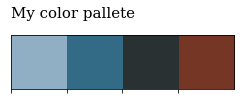

In [9]:
colors = ['#90afc5', '#336b87', '#2a3132', '#763626']

sns.palplot(colors)
plt.title('My color pallete', loc='left', fontfamily='serif', fontsize=15, y=1.2)
plt.show()

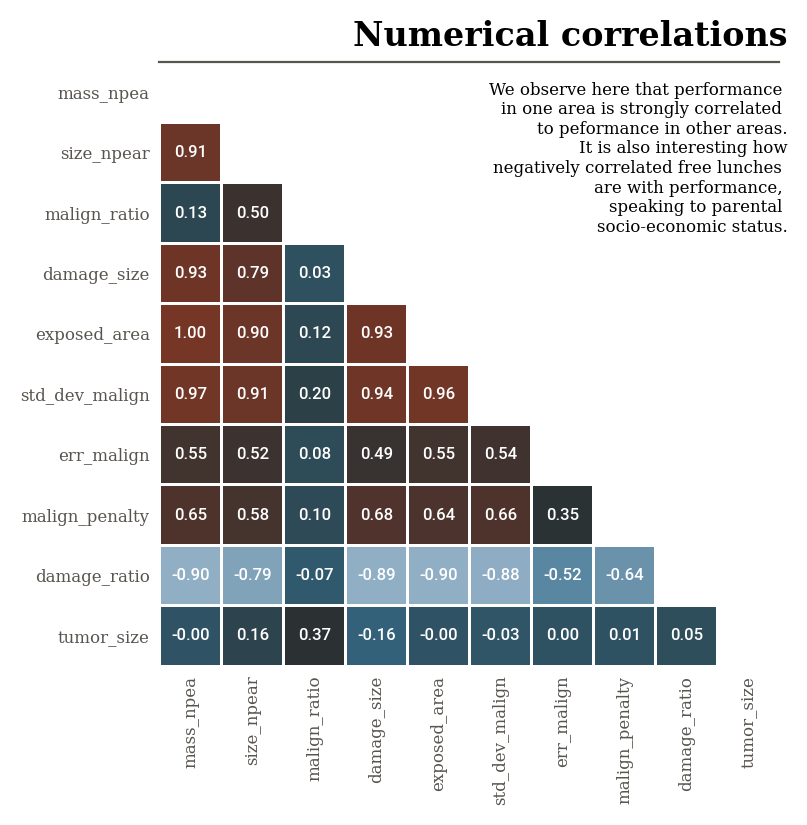

In [240]:
corr = df.corr()

# Setting up figure and axes
fig = plt.figure(figsize=(4, 4), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0.8)
ax0 = fig.add_subplot(gs[0, 0]) # create axis

mask = np.triu(corr)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=0.5, cmap=cmap, ax=ax0, annot_kws={'fontweight': 'bold', 'fontsize': 6})

ax0.set_yticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=6)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=6)

ax0.spines['top'].set_visible(True)
ax0.tick_params(axis='both', which='both', length=0)

fig.text(0.91, 0.90, 'Numerical correlations', fontweight='bold', 
         fontfamily='serif', fontsize=12, ha='right')
fig.text(0.91, 0.88, '''
We observe here that performance 
in one area is strongly correlated 
to peformance in other areas.
It is also interesting how
negatively correlated free lunches 
are with performance, 
speaking to parental 
socio-economic status.''', 
         fontweight='light', fontfamily='serif', fontsize=6, va='top', ha='right')

plt.tight_layout()
plt.show()

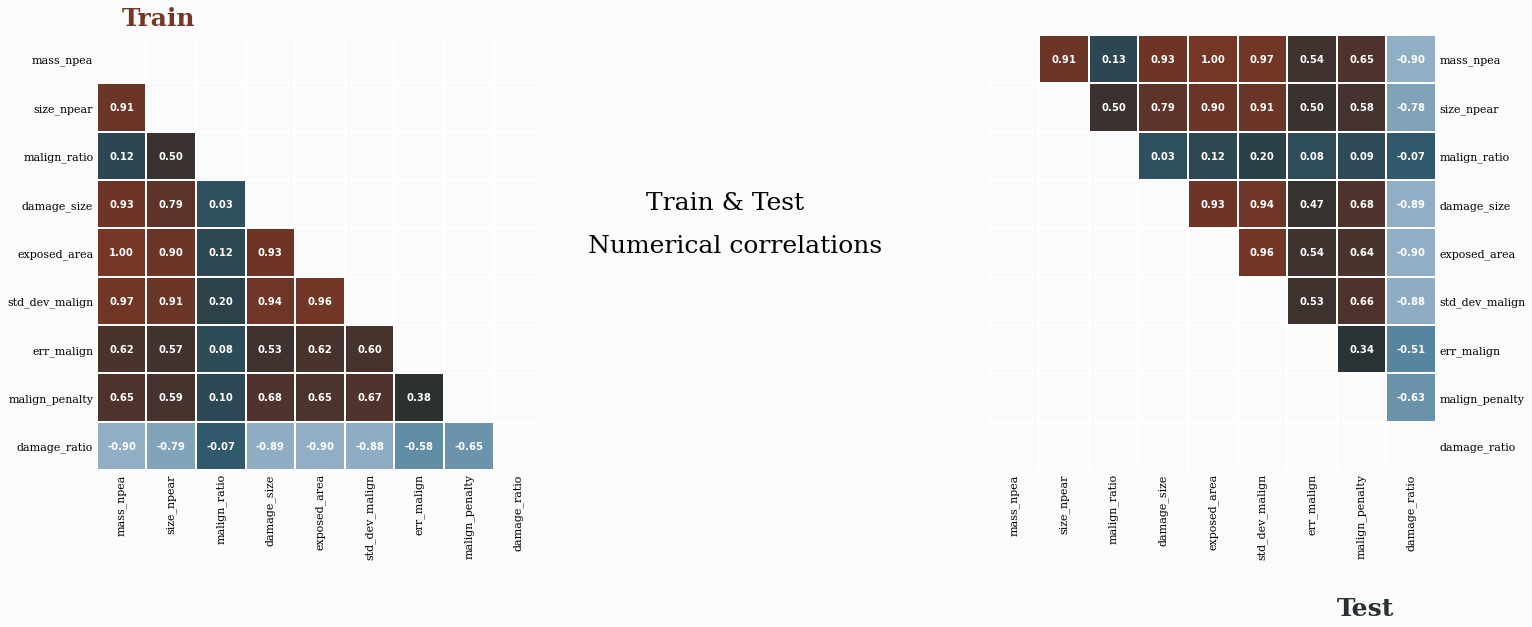

In [43]:
train_corr = raw_train.drop('tumor_size', axis=1).corr()
test_corr = raw_test.corr()

# Setting up figure and axes
fig = plt.figure(figsize=(24, 8)) # create figure
gs = fig.add_gridspec(1, 3)
gs.update(wspace=0, hspace=0.8)

fig.patch.set_facecolor(background_color)

axx = [None] * 3
for i in range(3):
    axx[i] = fig.add_subplot(gs[0, i])
    axx[i].set_facecolor(background_color)
# axx[0] = fig.add_subplot(gs[0, 0]) # create axis
# axx[2] = fig.add_subplot(gs[2, 0])
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

mask = np.triu(train_corr)
sns.heatmap(train_corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=2, cmap=cmap, ax=axx[0], annot_kws={'fontweight': 'bold'})

mask = np.tril(test_corr)
sns.heatmap(test_corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=2, cmap=cmap, ax=axx[2], annot_kws={'fontweight': 'bold'})


for i in range(3):
    axx[i].set_yticklabels(axx[i].get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
    axx[i].set_xticklabels(axx[i].get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)
    axx[i].tick_params(axis='both', which='both', length=0)
    

axx[2].yaxis.tick_right()
axx[1].set_xticklabels('')
axx[1].set_yticklabels('')

for loc in ['left', 'top', 'right', 'bottom']:
    axx[1].spines[loc].set_visible(False)
axx[1].text(0.23, 0.6, 'Train & Test', fontfamily='serif', fontsize=25)
axx[1].text(0.1, 0.5, 'Numerical correlations', fontfamily='serif', fontsize=25)


axx[0].text(0.5, -0.2, 'Train', fontweight='bold', 
         fontfamily='serif', fontsize=25, color='#763626')
axx[2].text(7, 12, 'Test', fontweight='bold', 
         fontfamily='serif', fontsize=25, color='#2a3132')


plt.tight_layout()
plt.show()

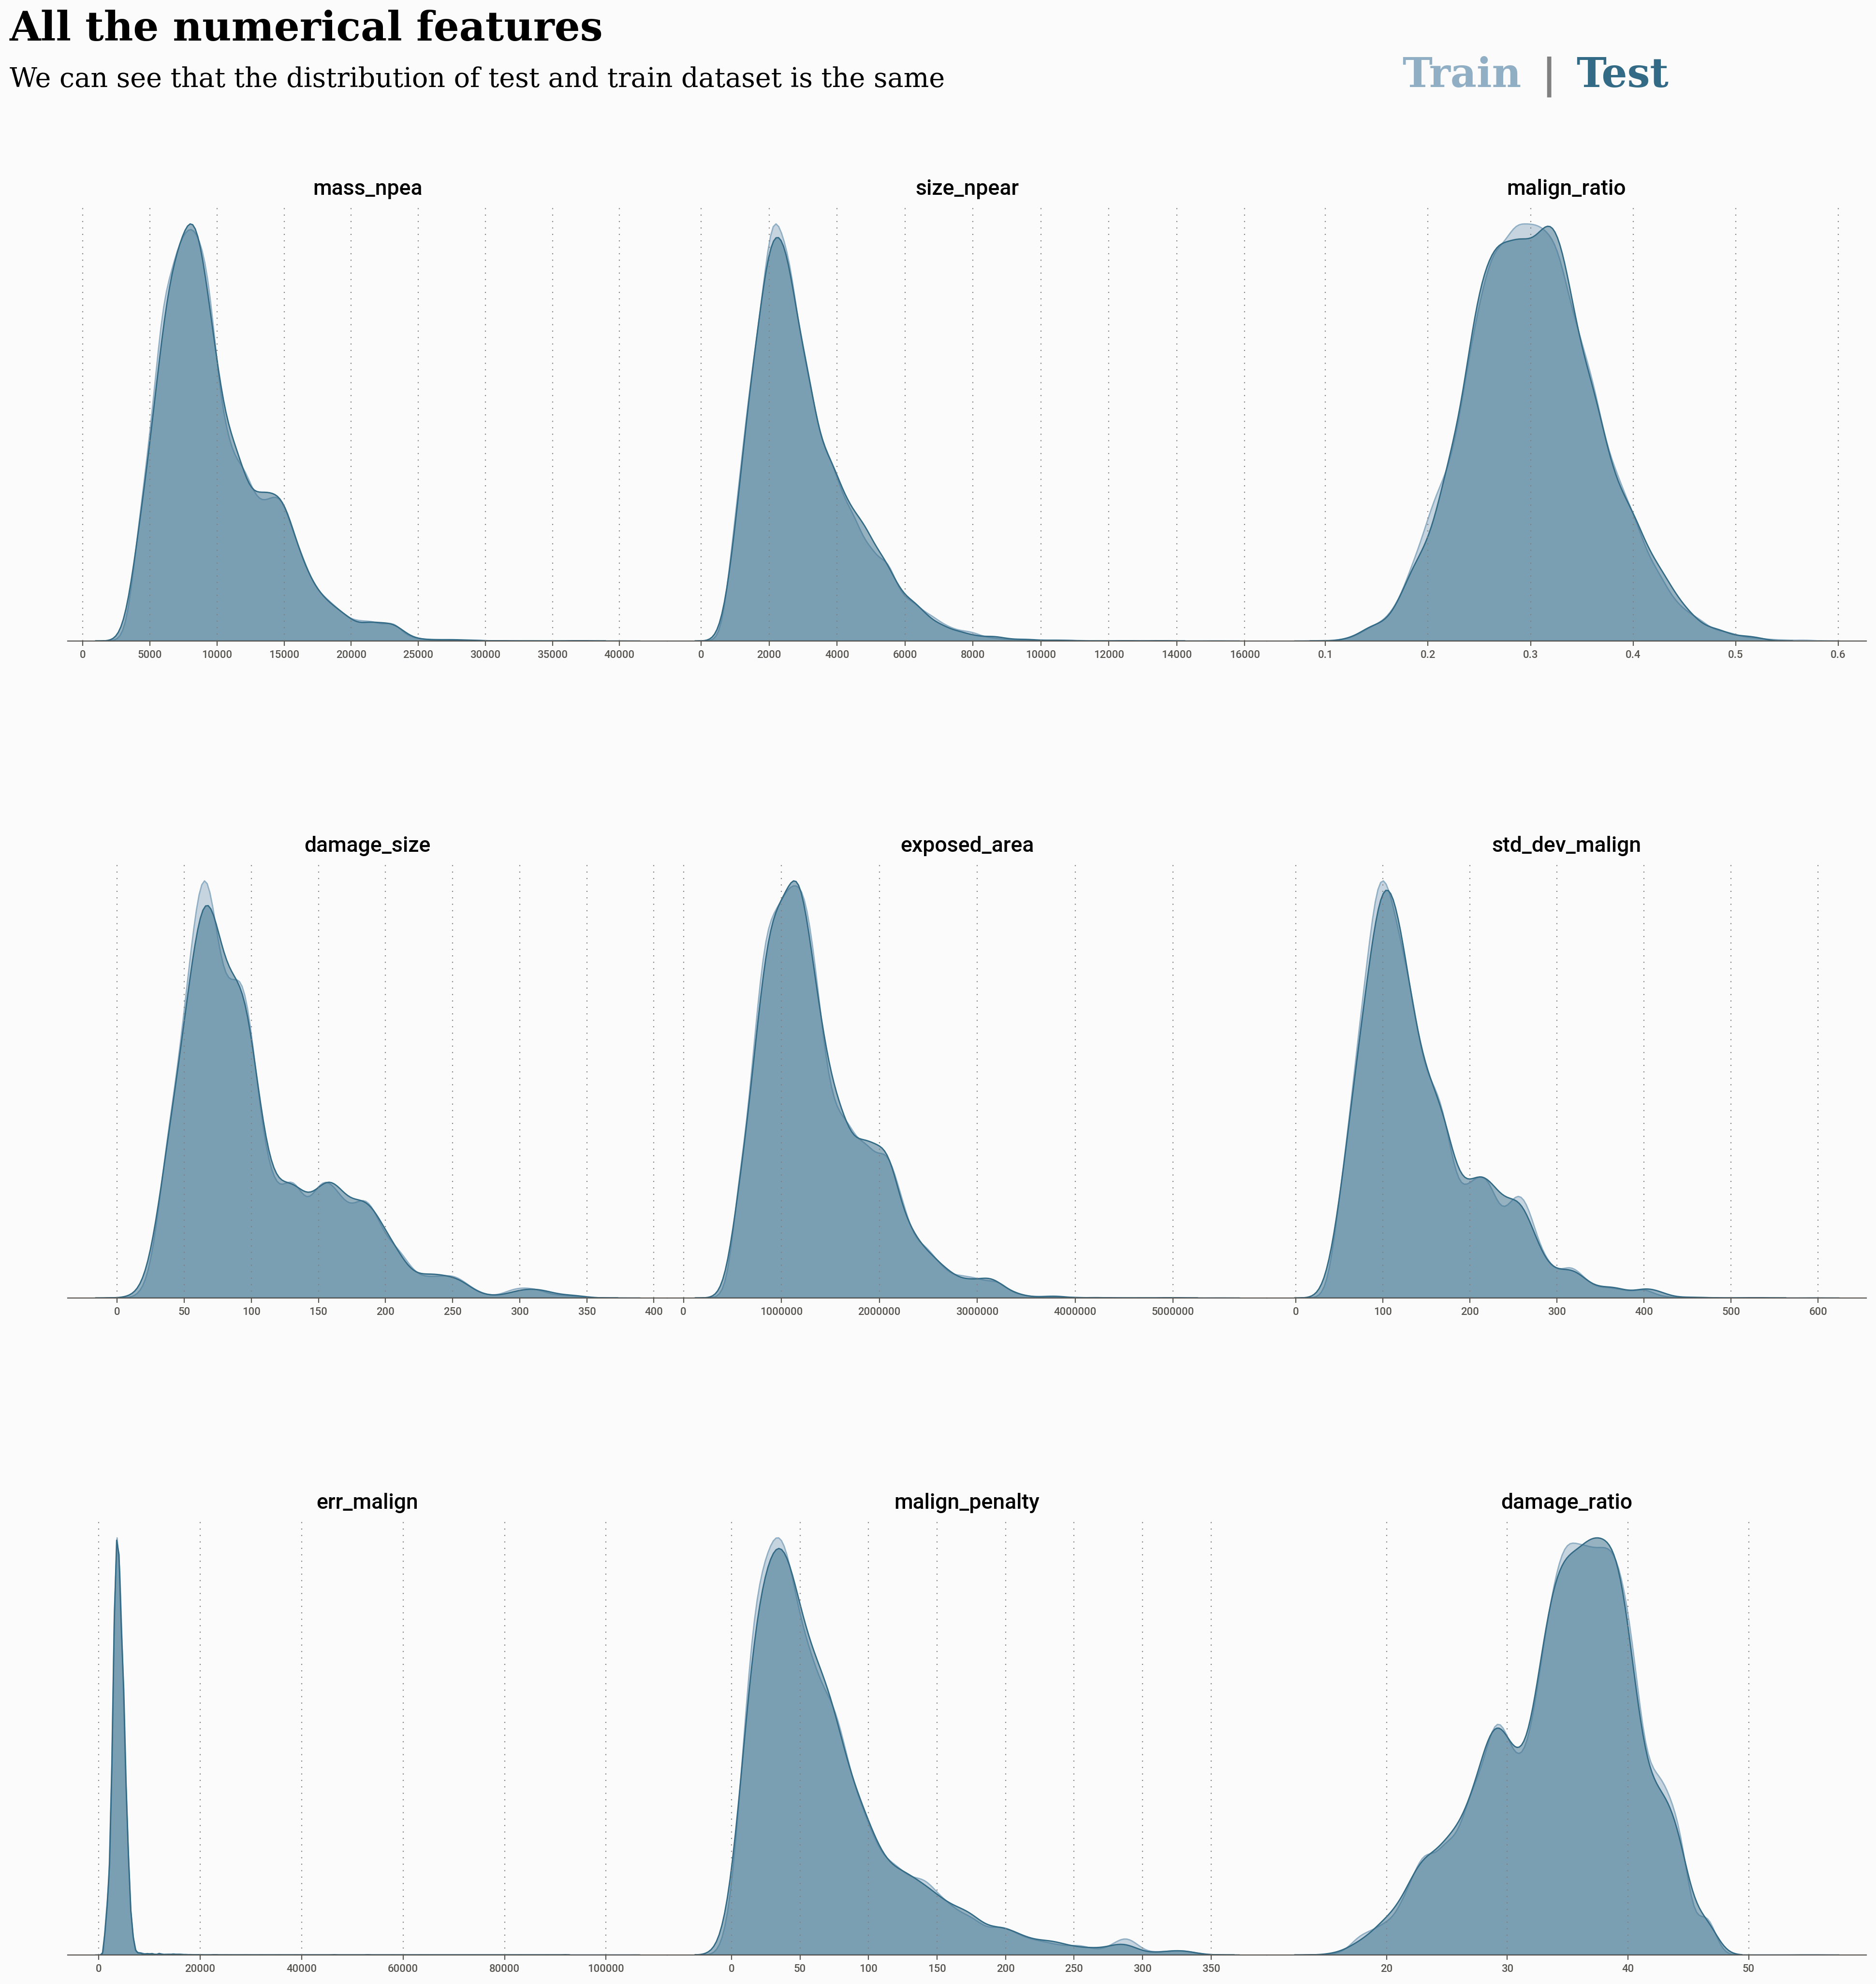

In [237]:
# Setting up figure and axes
fig = plt.figure(figsize=(24, 24), dpi=200) # create figure
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0, hspace=0.5)

fig.patch.set_facecolor(background_color)

axx = np.array([[None for _ in range(3)] for _ in range(3)])
for i in range(3):
    for j in range(3):
        axx[i, j] = fig.add_subplot(gs[i, j])
        axx[i, j].set_facecolor(background_color)
    

cols = raw_test.columns.tolist()
for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        sns.kdeplot(data=raw_test, x=cols[idx], shade=True, ax=axx[i, j], alpha=0.5, color='#90afc5')
        sns.kdeplot(data=raw_train, x=cols[idx], shade=True, ax=axx[i, j], alpha=0.5, color='#336b87')
        axx[i, j].set_title(cols[idx], fontsize=16)
        
        
for i in range(3):
    for j in range(3):
        axx[i, j].set_yticklabels('')
        axx[i, j].set_ylabel('')
        axx[i, j].set_xlabel('')
        axx[i, j].tick_params(axis='y', which='both', length=0)
        axx[i, j].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        for loc in ['left', 'top', 'right']:
            axx[i, j].spines[loc].set_visible(False)
            
fig.text(0.1, 0.95, 'All the numerical features', fontsize=30, fontfamily='serif', 
         fontweight='bold', ha='left')
fig.text(0.1, 0.93, 'We can see that the distribution of test and train dataset is the same',
         fontsize=20, fontfamily='serif', ha='left')

fig.text(0.7, 0.93, 'Train', fontsize=30, fontfamily='serif', 
         fontweight='bold', color='#90afc5')
fig.text(0.76, 0.93, '|', fontsize=30, fontfamily='serif', 
         fontweight='bold', color='gray')
fig.text(0.775, 0.93, 'Test', fontsize=30, fontfamily='serif', 
         fontweight='bold', color='#336b87')

plt.tight_layout()
plt.show()

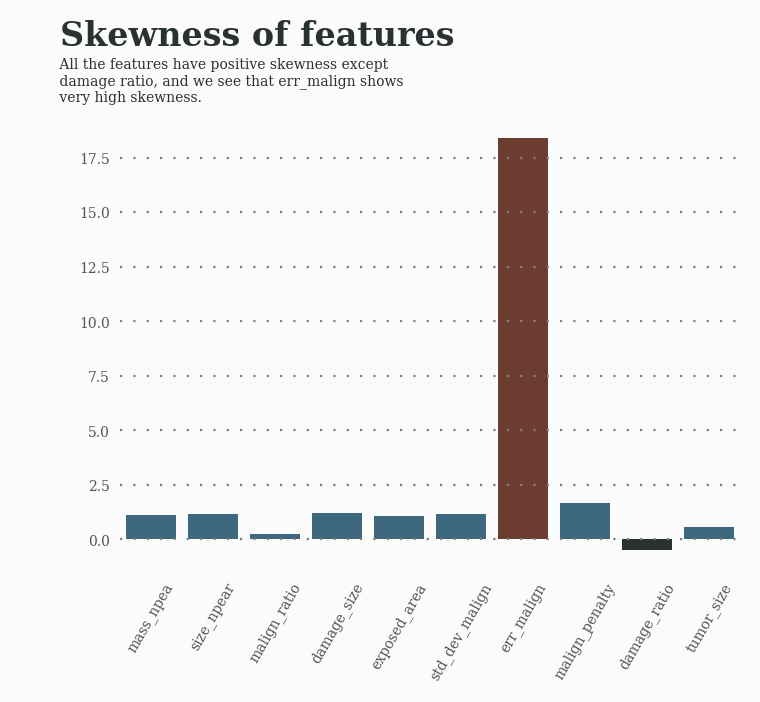

In [330]:
skew = raw_train.skew().reset_index()
skew

# Setting up figure and axes
fig = plt.figure(figsize=(4, 3), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=1)
ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

c = ['#336b87'] * 10
c[-2] = '#2a3132'
c[-4] = '#763626'

sns.barplot(data=skew, x='index', y=0, ax=ax0, palette=c)
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=60, fontsize=5)
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.tick_params(axis='both', which='both', length=0)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
for loc in ['left', 'top', 'right', 'bottom']:
    ax0.spines[loc].set_visible(False)
    
fig.text(0.05, 1, 'Skewness of features', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')
fig.text(0, 0.88, 
         '''
         All the features have positive skewness except 
         damage ratio, and we see that err_malign shows 
         very high skewness.
         ''',
         fontsize=5,
         fontfamily='serif',
         color='#2a3132',
)

plt.tight_layout()
plt.show()

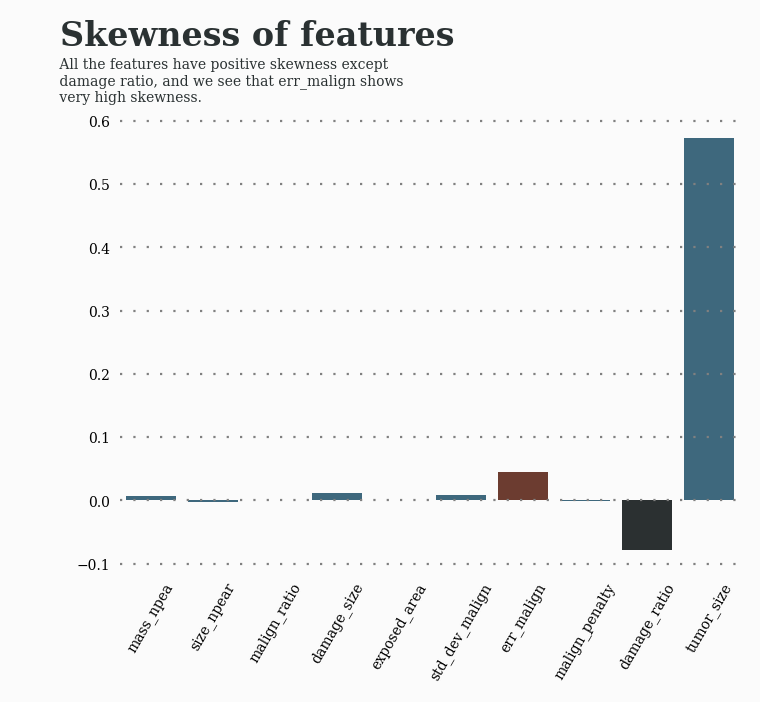

In [11]:
skew = df.skew().reset_index()
skew

# Setting up figure and axes
fig = plt.figure(figsize=(4, 3), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=1)
ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

c = ['#336b87'] * 10
c[-2] = '#2a3132'
c[-4] = '#763626'

sns.barplot(data=skew, x='index', y=0, ax=ax0, palette=c)
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=60, fontsize=5)
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.tick_params(axis='both', which='both', length=0)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
for loc in ['left', 'top', 'right', 'bottom']:
    ax0.spines[loc].set_visible(False)
    
fig.text(0.05, 1, 'Skewness of features', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')
fig.text(0, 0.88, 
         '''
         All the features have positive skewness except 
         damage ratio, and we see that err_malign shows 
         very high skewness.
         ''',
         fontsize=5,
         fontfamily='serif',
         color='#2a3132',
)

plt.tight_layout()
plt.show()

In [52]:
target_col = 'tumor_size'
mask = df[target_col].isna() == True

train = df.loc[~mask]
train[target_col] = train[target_col]

test = df.loc[mask].drop(target_col, axis=1)

In [53]:
train.to_csv('../data/clean_train1.csv', index=False)
test.to_csv('../data/clean_test1.csv', index=False)